# Detect Sleep States DataPrepare

### This notebook is inspired by the following [werus23's](https://www.kaggle.com/werus23) amazing notebooks.
### see also them.

Finding Critical Points using RNNs

 - [Data Prep notebook](https://www.kaggle.com/code/werus23/sleep-critical-point-prepare-data)
 - [Training notebook](https://www.kaggle.com/werus23/sleep-critical-point-train)
 - [Inference Notebook](https://www.kaggle.com/code/werus23/sleep-critical-point-infer)

Credits:

 - idea: https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/discussion/441470
 - dataloader: https://www.kaggle.com/code/henriupton/efficient-loading-memory-usage-visualizations-cmi
 - arch: https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction/discussion/416410

My other works
- [Data preparation Notebook](https://www.kaggle.com/code/itsuki9180/detect-sleep-states-dataprepare)
- [Training Notebook](https://www.kaggle.com/code/itsuki9180/detect-sleep-states-train) 
- [Inference Notebook](https://www.kaggle.com/code/itsuki9180/detect-sleep-states-dataprepare) <- you are viewing now

In [1]:
import pandas as pd
import numpy as np
import gc
import time
import json
from datetime import datetime
import matplotlib.pyplot as plt
import os
import joblib
import random
import math
from tqdm import tqdm 

from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import argrelmax

from math import pi, sqrt, exp
import sklearn,sklearn.model_selection
from sklearn.metrics import mean_squared_error
import torch
from torch import nn,Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.metrics import average_precision_score
from timm.scheduler import CosineLRScheduler
plt.style.use("ggplot")

from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import ctypes
torch.set_num_interop_threads(4)
torch.set_num_threads(4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Fundamental config
WORKERS = os.cpu_count()//2
N_FOLDS = 5
TRAIN_FOLD = 0

In [3]:
class PATHS:
    MAIN_DIR = "/kaggle/input/child-mind-institute-detect-sleep-states/"
    # CSV FILES : 
    SUBMISSION = MAIN_DIR + "sample_submission.csv"
    TRAIN_EVENTS = MAIN_DIR + "train_events.csv"
    # PARQUET FILES:
    TRAIN_SERIES = MAIN_DIR + "train_series.parquet"
    TEST_SERIES = MAIN_DIR + "test_series.parquet"
class CFG:
    DEMO_MODE = True
class data_reader:
    def __init__(self, demo_mode):
        super().__init__()
        # MAPPING FOR DATA LOADING :
        self.names_mapping = {
            "submission" : {"path" : PATHS.SUBMISSION, "is_parquet" : False, "has_timestamp" : False}, 
            "train_events" : {"path" : PATHS.TRAIN_EVENTS, "is_parquet" : False, "has_timestamp" : True},
            "train_series" : {"path" : PATHS.TRAIN_SERIES, "is_parquet" : True, "has_timestamp" : True},
            "test_series" : {"path" : PATHS.TEST_SERIES, "is_parquet" : True, "has_timestamp" : True}
        }
        self.valid_names = ["submission", "train_events", "train_series", "test_series"]
        self.demo_mode = demo_mode
    
    def verify(self, data_name):
        "function for data name verification"
        if data_name not in self.valid_names:
            print("PLEASE ENTER A VALID DATASET NAME, VALID NAMES ARE : ", valid_names)
        return
    
    def cleaning(self, data):
        "cleaning function : drop na values"
        before_cleaning = len(data)
        print("Number of missing timestamps : ", len(data[data["timestamp"].isna()]))
        data = data.dropna(subset=["timestamp"])
        after_cleaning = len(data)
        print("Percentage of removed rows : {:.1f}%".format(100 * (before_cleaning - after_cleaning) / before_cleaning) )
#         print(data.isna().any())
#         data = data.bfill()
        return data
    
    @staticmethod
    def reduce_memory_usage(data):
        "iterate through all the columns of a dataframe and modify the data type to reduce memory usage."
        start_mem = data.memory_usage().sum() / 1024**2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
        for col in data.columns:
            col_type = data[col].dtype    
            if col_type != object:
                c_min = data[col].min()
                c_max = data[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        data[col] = data[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        data[col] = data[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        data[col] = data[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        data[col] = data[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        data[col] = data[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        data[col] = data[col].astype(np.float32)
                    else:
                        data[col] = data[col].astype(np.float64)
            else:
                data[col] = data[col].astype('category')

        end_mem = data.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        return data
    
    def load_data(self, data_name):
        "function for data loading"
        self.verify(data_name)
        data_props = self.names_mapping[data_name]
        if data_props["is_parquet"]:
            if self.demo_mode:
                pf = ParquetFile(data_props["path"]) 
                demo_rows = next(pf.iter_batches(batch_size=20_000)) 
                data = pa.Table.from_batches([demo_rows]).to_pandas()
            else:
                data = pd.read_parquet(data_props["path"])
        else:
            if self.demo_mode:
                data = pd.read_csv(data_props["path"], nrows=20_000)
            else:
                data = pd.read_csv(data_props["path"])
                
        gc.collect()
        if data_props["has_timestamp"]:
            print('cleaning')
            data = self.cleaning(data)
            gc.collect()
        #data = self.reduce_memory_usage(data)
        return data

In [4]:
reader = data_reader(demo_mode=False)
test_series = reader.load_data(data_name="test_series")
ids = test_series.series_id.unique()
gc.collect()

cleaning
Number of missing timestamps :  0
Percentage of removed rows : 0.0%


0

In [5]:
def seq_block(in_features, out_features, ks=3, drop_rate=0.2, dilation=1):
    padding = ((ks-1)*dilation)//2
    return nn.Sequential(
        nn.Conv1d(in_features, out_features, ks, padding=padding, dilation=dilation),
        nn.BatchNorm1d(out_features),
        nn.LeakyReLU(0.2),
        nn.Dropout(drop_rate)
    )

class SimpleConvNet(nn.Module):
    def __init__(self, in_c=2, out_c=2, hidden=128, emb_dim=8, ks=3, n_blks=3, dropout=0.2):
        super(SimpleConvNet, self).__init__()
        
        self.hr_emb = nn.Embedding(24, emb_dim)
        self.fc1_hr = nn.Linear(emb_dim, emb_dim)
        self.fc2_hr = nn.Linear(emb_dim, emb_dim)
        
        self.fc_in = nn.Linear(in_c+emb_dim, hidden)
        self.blks = nn.Sequential(
            *[seq_block(hidden, hidden, ks, drop_rate=dropout, dilation=2**i) for i in range(n_blks)]
            )
        self.fc_out = nn.Linear(hidden, out_c)
        
        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x, h):        
        e = self.hr_emb(h)
        e = self.fc1_hr(e)
        e = self.lrelu(e)
        e = self.fc2_hr(e)

        x = torch.cat([x, e.squeeze(2)], dim=-1)
        x = self.fc_in(x)
        
        x = x.permute(0,2,1)
        
        for b in self.blks:
            x = b(x)

        x = x.permute(0,2,1)
        
        x = self.fc_out(x)
        return x

In [6]:
SIGMA = 720 #average length of day is 24*60*12 = 17280 for comparison
SAMPLE_FREQ = 12 # 1 obs per minute
class SleepTestDataset(Dataset):
    def __init__(
        self,
        test_series,
        test_ids
    ):
        self.enmo_mean = np.load('/kaggle/input/itsuki-dataprepare-with-lightweight/enmo_mean.npy')
        self.enmo_std = np.load('/kaggle/input/itsuki-dataprepare-with-lightweight/enmo_std.npy')

        self.Xs = self.conv_dfs(test_series, test_ids)
        
        self.feat_list = np.load('/kaggle/input/itsuki-train-lightweight/feature_list.npy')
        self.label_list = ['onset', 'wakeup']
        
        self.hour_feat= ['hour']
        
            
    def conv_dfs(self, series, ids):
        res = []
        for j, viz_id in tqdm(enumerate(ids), total=len(ids)):
            viz_series = series.loc[(series.series_id==viz_id)].copy().reset_index()
            viz_series['dt'] = pd.to_datetime(viz_series.timestamp,format = '%Y-%m-%dT%H:%M:%S%z').astype("datetime64[ns, UTC-04:00]")
            viz_series['hour'] = viz_series['dt'].dt.hour
            new_df = viz_series[['step', 'anglez', 'enmo', 'hour']]
            res.append(new_df)

        return res

    def norm_feat_eng(self, X, init=False):
        X['anglez'] = X['anglez'] / 90.0
        X['enmo'] = (X['enmo']-self.enmo_mean)/ (self.enmo_std+1e-8)
        
        for w in [1, 2, 4, 8, 16]:    
            X['anglez_shift_pos_' + str(w)] = X['anglez'].shift(w).fillna(0)
            X['anglez_shift_neg_' + str(w)] = X['anglez'].shift(-w).fillna(0)
            
            X['enmo_shift_pos_' + str(w)] = X['enmo'].shift(w).fillna(0)
            X['enmo_shift_neg_' + str(w)] = X['enmo'].shift(-w).fillna(0)
            
            if init:
                self.feat_list.append('anglez_shift_pos_' + str(w))
                self.feat_list.append('anglez_shift_neg_' + str(w))
                
                self.feat_list.append('enmo_shift_pos_' + str(w))
                self.feat_list.append('enmo_shift_neg_' + str(w))
            
        for r in [17, 33, 65]:
            tmp_anglez = X['anglez'].rolling(r, center=True)
            X[f'anglez_mean_{r}'] = tmp_anglez.mean()
            X[f'anglez_std_{r}'] = tmp_anglez.std()            
            
            tmp_enmo = X['enmo'].rolling(r, center=True)
            X[f'enmo_mean_{r}'] = tmp_enmo.mean()
            X[f'enmo_std_{r}'] = tmp_enmo.std()
            
            if init:
                self.feat_list.append(f'anglez_mean_{r}')
                self.feat_list.append(f'anglez_std_{r}')

                self.feat_list.append(f'enmo_mean_{r}')
                self.feat_list.append(f'enmo_std_{r}')
                
        X = X.fillna(0)
        
        return X.astype(np.float32)

    def gauss(self,n=SIGMA,sigma=SIGMA*0.15):
        # guassian distribution function
        r = range(-int(n/2),int(n/2)+1)
        return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]
    
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, index):
        X = self.Xs[index]
        X = self.norm_feat_eng(X, init=False)
        x = X[self.feat_list].values.astype(np.float32)     
        t = X[self.hour_feat].values.astype(np.int32)
        return x, t

test_ds = SleepTestDataset(test_series, ids)

100%|██████████| 3/3 [00:00<00:00, 102.16it/s]


In [7]:
test_ds[0][0].shape

(150, 34)

In [8]:
if len(test_ds.Xs)==3:
    for x in test_ds.Xs:
        display(x)

,step,anglez,enmo,hour,anglez_shift_pos_1,anglez_shift_neg_1,enmo_shift_pos_1,enmo_shift_neg_1,anglez_shift_pos_2,anglez_shift_neg_2,...,enmo_mean_17,enmo_std_17,anglez_mean_33,anglez_std_33,enmo_mean_33,enmo_std_33,anglez_mean_65,anglez_std_65,enmo_mean_65,enmo_std_65
0,0,0.029297,-0.196482,15,0.000000,0.029298,0.000000,-0.198241,0.000000,0.029300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.029298,-0.198241,15,0.029297,0.029300,-0.196482,-0.197362,0.000000,0.029298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.029300,-0.197362,15,0.029298,0.029298,-0.198241,-0.200000,0.029297,0.029298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.029298,-0.200000,15,0.029300,0.029298,-0.197362,-0.198241,0.029298,0.029297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.029298,-0.198241,15,0.029298,0.029297,-0.200000,-0.196482,0.029300,0.029297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,145,-0.888784,-0.268592,15,-0.890966,-0.889211,-0.267713,-0.267713,-0.890640,-0.888992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,146,-0.889211,-0.267713,15,-0.888784,-0.888992,-0.268592,-0.266834,-0.890966,-0.889632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,147,-0.888992,-0.266834,15,-0.889211,-0.889632,-0.267713,-0.268592,-0.888784,-0.890594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,148,-0.889632,-0.268592,15,-0.888992,-0.890594,-0.266834,-0.267713,-0.889211,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,step,anglez,enmo,hour
0,0,38.892899,0.0803,12
1,1,29.374399,0.0752,12
2,2,37.225101,0.1791,12
3,3,46.937000,0.0922,12
4,4,60.486698,0.0342,12
...,...,...,...,...
145,145,-88.216599,0.0000,12
146,146,-88.216599,0.0000,12
147,147,-88.216599,0.0000,12
148,148,-88.216599,0.0000,12


,step,anglez,enmo,hour
0,0,-77.314903,0.0868,13
1,1,-52.183800,0.0434,13
2,2,-53.218601,0.0541,13
3,3,-51.541698,0.0612,13
4,4,-24.637300,0.0591,13
...,...,...,...,...
145,145,-59.696899,0.0601,13
146,146,-35.656601,0.0427,13
147,147,-21.582399,0.0309,13
148,148,-42.616001,0.0328,13


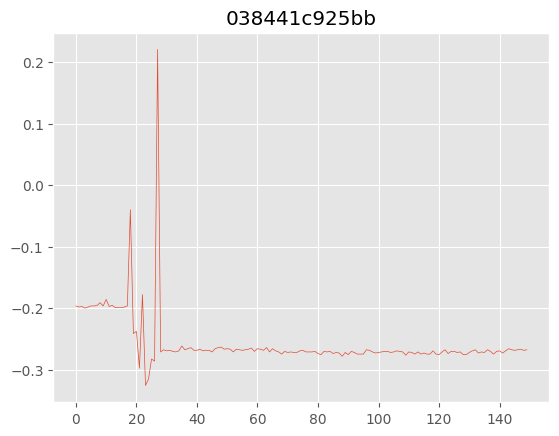

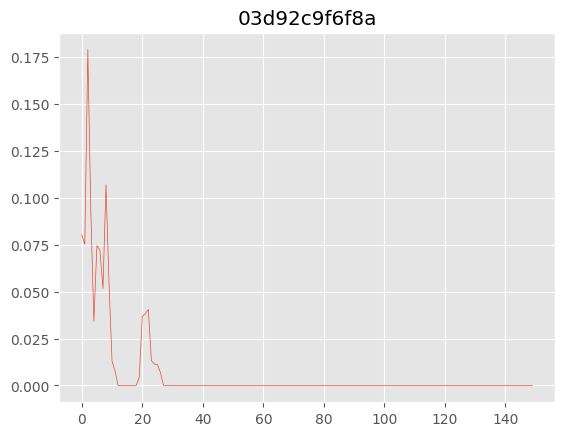

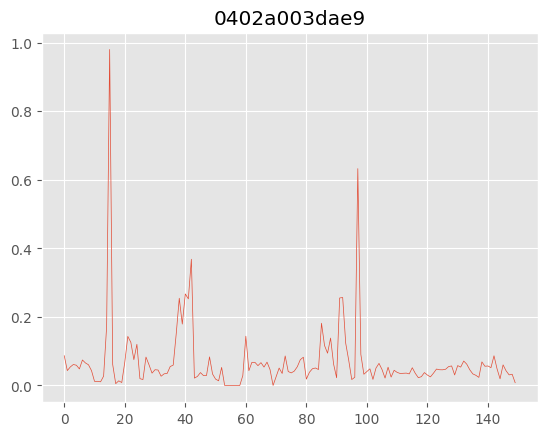

In [9]:
if len(test_ds.Xs)==3:
    for i, x in enumerate(test_ds.Xs):
        plt.plot(x['enmo'], lw=0.5)
        plt.title(ids[i])
        plt.show()

In [10]:
del test_series, reader
gc.collect()

11056

In [11]:
# Model config
HIDDEN = 256 
EMB_DIM = 16
KS = 31 
N_BLKS = 5 
DROPOUT = 0.2

In [12]:
test_dl = DataLoader(
    test_ds,
    batch_size=1,
    pin_memory=True,
    num_workers=WORKERS,
    shuffle=False,
    drop_last=False
)

In [13]:
model = SimpleConvNet(in_c=len(test_ds.feat_list), out_c=2, hidden=HIDDEN, emb_dim=EMB_DIM, ks=KS, n_blks=N_BLKS, dropout=DROPOUT).to(device)
model.load_state_dict(torch.load(f'/kaggle/input/itsuki-train-lightweight/model_best_fold-{TRAIN_FOLD}.pth',map_location=device))
model.eval().half()

SimpleConvNet(
  (hr_emb): Embedding(24, 16)
  (fc1_hr): Linear(in_features=16, out_features=16, bias=True)
  (fc2_hr): Linear(in_features=16, out_features=16, bias=True)
  (fc_in): Linear(in_features=50, out_features=256, bias=True)
  (blks): Sequential(
    (0): Sequential(
      (0): Conv1d(256, 256, kernel_size=(31,), stride=(1,), padding=(15,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(256, 256, kernel_size=(31,), stride=(1,), padding=(30,), dilation=(2,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Conv1d(256, 256, kernel_size=(31,), stride=(1,), padding=(60,), dilation=(4,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, 

In [14]:
autocast = torch.cuda.amp.autocast(enabled=True, dtype=torch.half)
scaler = torch.cuda.amp.GradScaler(enabled=True, init_scale=4096)

In [15]:
def lpf(wave, fs=12*60*24, fe=60, n=3):
    nyq = fs / 2.0
    b, a = signal.butter(1, fe/nyq, btype='low')
    for i in range(0, n):
        wave = signal.filtfilt(b, a, wave)
    return wave

In [16]:
submission = pd.DataFrame()

In [17]:
with torch.no_grad():
    with tqdm(test_dl, leave=True) as pbar:
        for i, (X_batch, hr_batch) in enumerate(pbar):
            X_batch = X_batch.to(device)
            hr_batch = hr_batch.to(device)
            with autocast:
                y_pred = model(X_batch, hr_batch)

            y_pred = y_pred[0].sigmoid().cpu().numpy().astype(np.float32)
            
            before_RMSE = np.sqrt(mean_squared_error(y_pred, np.zeros_like(y_pred)))
            
            if len(test_ds.Xs)!=3:
                y_pred[:,0] = lpf(y_pred[:,0])
                y_pred[:,1] = lpf(y_pred[:,1])
            
            after_RMSE = np.sqrt(mean_squared_error(y_pred, np.zeros_like(y_pred)))

            decay_ratio = before_RMSE/after_RMSE
            y_pred *= decay_ratio
            
            onset_candi = argrelmax(y_pred[:, 0], order=12*60*6) # 12*60*6 = 6hours
            wakeup_candi = argrelmax(y_pred[:, 1], order=12*60*6) # 12*60*6 = 6hours
            

            series_id = ids[i]
            try:                
                onset_candi = onset_candi[0]
                onset = pd.DataFrame({'series_id': [series_id]*len(onset_candi),
                                     'step': onset_candi,
                                     'score': y_pred[onset_candi, 0].reshape(-1),
                                     'event': ['onset']*len(onset_candi)})
            except:
                 onset = pd.DataFrame()
            
            try:
                wakeup_candi = wakeup_candi[0]
                wakeup = pd.DataFrame({'series_id': [series_id]*len(wakeup_candi),
                                     'step': wakeup_candi,
                                     'score': y_pred[wakeup_candi, 1].reshape(-1),
                                     'event': ['wakeup']*len(wakeup_candi)})
            except:
                wakeup = pd.DataFrame()
            
            submission = pd.concat([submission, onset, wakeup], axis=0)

100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


In [18]:
submission = submission.sort_values(['series_id','step']).reset_index(drop=True)
submission['row_id'] = submission.index.astype(int)
submission['score'] = submission['score'].fillna(submission['score'].mean())
submission = submission[['row_id','series_id','step','event','score']]
submission.to_csv('submission.csv',index=False)

In [19]:
submission

,row_id,series_id,step,event,score
0,0,038441c925bb,24,wakeup,0.198853
1,1,038441c925bb,104,onset,0.114990
2,2,03d92c9f6f8a,134,wakeup,0.132446
3,3,03d92c9f6f8a,145,onset,0.168945
4,4,0402a003dae9,14,wakeup,0.131714
